# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías El Dócil




#### Objetivo
Determinar, para cada usuario presentado, cuál es la probabilidad de que ese
usuario realice una conversión en Trocafone en un periodo determinado.

#### Fuentes
El archivo "events_up_to_01062018.csv" contiene en el mismo formato utilizado en el TP1
información de eventos realizado en la plataforma para un conjunto de usuarios hasta el
31/05/2018.

Por otro lado el archivo "labels_training_set.csv" indica para un subconjunto de los
usuarios incluidos en el set de eventos "events_up_to_01062018.csv" si los mismos
realizaron una conversión (columna label = 1) o no (columna label = 0) desde el 01/06/2018
hasta el 15/06/2018.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

%matplotlib inline

pd.set_option('display.max_columns', 51)

In [2]:
# Carga del set de datos de eventos
eventos = pd.read_csv('../dataset/events_up_to_01062018.csv', low_memory=False)
# Carga del set de datos de labels
labels = pd.read_csv('../dataset/labels_training_set.csv', low_memory=False)


In [3]:
eventos.shape

(2341681, 23)

In [4]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
1340575,2018-04-13 12:46:03,viewed product,399a78a8,NaN,297.0,iPhone 5s,Muito Bom,32GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
993018,2018-05-02 20:17:16,viewed product,10871bbb,NaN,9398.0,Samsung Galaxy A5 2016,Bom,16GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1199204,2018-05-31 15:18:38,search engine hit,017fd805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1694765,2018-04-27 11:38:23,viewed product,89a3cd57,NaN,8512.0,Samsung Galaxy S7 Edge,Muito Bom,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905575,2018-05-22 00:59:43,generic listing,02208eb6,NaN,NaN,NaN,NaN,NaN,NaN,"6594,6637,6665,6649,2750,2820,12618,12604,1134...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Formateo los eventos
eventos['timestamp'] = pd.to_datetime(eventos['timestamp'])

## Feature: Marca Favorita

Para cada persona, se indicara su marca favorita, que significa la marca que mas checkouts, conversiones y viewed product.

Filtro de eventos las columnas person y model

In [6]:
marcas = eventos.loc[:, ['person', 'model']]

Agrego columnas que categorizan el modelo por marca

In [7]:
marcas['apple'] = (marcas['model'].str.contains('iphone', case=False)) | (marcas['model'].str.contains('ipad', case=False))
marcas['motorola'] = marcas['model'].str.contains('motorola', case=False)
marcas['samsung'] = marcas['model'].str.contains('samsung', case=False)
marcas['lg'] = marcas['model'].str.contains('lg', case=False)
marcas['blackberry'] = marcas['model'].str.contains('blackberry', case=False)
marcas['sony'] = marcas['model'].str.contains('sony', case=False)
marcas['asus'] = marcas['model'].str.contains('asus', case=False)
marcas['lenovo'] = marcas['model'].str.contains('lenovo', case=False)
marcas['quantum'] = marcas['model'].str.contains('quantum', case=False)

Los usuarios que nunca realizaron algun evento del tipo "checkout", "conversion" o "viewed product" no tendrán marcas asociadas, de ahí los valores NaN. Los descarto ya que no son representativos.

In [8]:
marcas = marcas[pd.notnull(marcas['model'])]
marcas.sample(15)

,person,model,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
1269392,622b4acf,Samsung Galaxy J2 4G Duos TV,False,False,True,False,False,False,False,False,False
1034213,91960583,Samsung Galaxy A5 2016,False,False,True,False,False,False,False,False,False
1546867,1bf1aeef,Samsung Galaxy A5,False,False,True,False,False,False,False,False,False
1394525,5b0a38d2,iPhone 6S,True,False,False,False,False,False,False,False,False
1452579,377de8ad,iPhone 6,True,False,False,False,False,False,False,False,False
933063,e289012c,Samsung Galaxy S6 Flat,False,False,True,False,False,False,False,False,False
365824,091d4e3a,iPhone 6S,True,False,False,False,False,False,False,False,False
234638,41ccd2c6,Samsung Galaxy S7 Edge,False,False,True,False,False,False,False,False,False
161293,dc2d6173,Samsung Galaxy S7 Edge,False,False,True,False,False,False,False,False,False
1510391,80b117ef,iPhone 7,True,False,False,False,False,False,False,False,False


In [9]:
marcas.loc[(marcas['apple'] == False) & (marcas['motorola'] == False) & (marcas['samsung'] == False) & (marcas['lg'] == False) & (marcas['blackberry'] == False) & (marcas['sony'] == False) & (marcas['asus'] == False) & (marcas['lenovo'] == False) & (marcas['quantum'] == False), :]['model'].value_counts()

Xiaomi Redmi 2      1
Outros TV LED 15    1
Name: model, dtype: int64

Ya no se necesita la columna "modelo", pues tenemos cada marca categorizada por columnas.

In [10]:
marcas = marcas.drop('model', axis=1)
marcas.head()

,person,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
0,4886f805,False,False,True,False,False,False,False,False,False
1,ad93850f,True,False,False,False,False,False,False,False,False
2,0297fc1e,True,False,False,False,False,False,False,False,False
3,2d681dd8,True,False,False,False,False,False,False,False,False
4,cccea85e,False,False,False,True,False,False,False,False,False


Agrupamos por persona sumando cada tipo de marca asociada.

In [11]:
marcas = marcas.groupby('person').agg({'apple':'sum', 'motorola':'sum', 'samsung': 'sum', 'lg':'sum', 'blackberry':'sum', 'sony':'sum', 'asus':'sum', 'lenovo':'sum', 'quantum':'sum'})

Las sumas vuelven en tipo object, las pasamos a float.

In [12]:
marcas = marcas.astype('float64')

Nos quedamos con la marca favorita de cada persona con idmax(axis=1)

In [13]:
marcas['marca_favorita'] = marcas.idxmax(axis=1)
marcas.sample(10)
marcas = marcas.reset_index()

In [14]:
marcas_favoritas = marcas.loc[:, ['person', 'marca_favorita']]
marcas_favoritas.head()

,person,marca_favorita
0,0008ed71,apple
1,00091926,apple
2,00091a7a,apple
3,000ba417,samsung
4,000c79fe,apple


In [15]:
marcas_favoritas['marca_favorita'].value_counts()

apple       16613
samsung     16410
motorola     4406
lg            434
sony          192
lenovo        158
asus           32
quantum        11
Name: marca_favorita, dtype: int64

Text(0.5,0,'Marca Favorita')

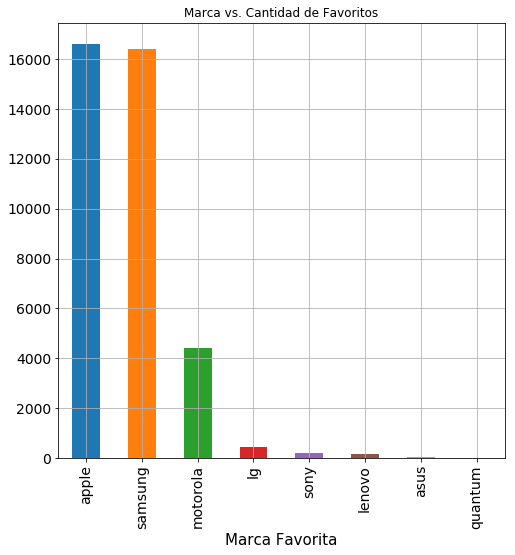

In [16]:
marcas_favoritas['marca_favorita'].value_counts().plot(kind='bar', figsize=(8,8), grid=True, fontsize=14, title='Marca vs. Cantidad de Favoritos').set_xlabel('Marca Favorita', size=15)

In [17]:
marcas_favoritas.shape

(38256, 2)

Liberamos recursos

In [18]:
marcas = 0

## Feature: Nivel de actividad de Usuario

Para cada persona, se creará una categoría que indicará su nivel de actividad en la plataforma. Para elaborar la misma, se generarán tres métricas distintas:

1. (A) Cantidad de eventos totales por persona
2. (B) Días distintos con eventos por persona
3. (C) Tiempo en la plataforma

Luego, se generarán distintos indicadores a partir de estas tres métricas, con el objetivo de obtener una medida confiable y representativa del nivel de actividad del usuario. Cada uno de estos indicadores se llamará Approach.

In [19]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
1082550,2018-05-27 18:28:48,viewed product,0c118b5a,NaN,290.0,iPhone 5s,Muito Bom,16GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109484,2018-05-13 12:17:06,search engine hit,c380ceab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164526,2018-05-29 13:12:40,ad campaign hit,569af484,/comprar/iphone/iphone-6s-plus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927748,2018-05-20 20:41:43,generic listing,f10ec6ec,NaN,NaN,NaN,NaN,NaN,NaN,"6594,6637,6649,7237,6707,2820,2750,12619,11346...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584649,2018-05-13 12:53:53,viewed product,80b09d78,NaN,10197.0,iPhone 7 Plus,Muito Bom,128GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
actividad_timestamp = eventos[['person', 'timestamp']] 

#### (A) Obtengo la cantidad de días que cada usuario tiene en la plataforma

In [21]:
dias_en_plataforma = actividad_timestamp.groupby('person').agg({'timestamp': ['min','max']}).reset_index()
dias_en_plataforma.columns = ['person', 'min', 'max']
dias_en_plataforma['dias_en_plataforma'] = dias_en_plataforma['max'] - dias_en_plataforma['min']
dias_en_plataforma['dias_en_plataforma_float'] = (dias_en_plataforma['dias_en_plataforma'].dt.total_seconds() / (60*60*24))
dias_en_plataforma = dias_en_plataforma.drop(['min','max','dias_en_plataforma'],axis=1)
dias_en_plataforma = dias_en_plataforma.rename(columns={'dias_en_plataforma_float':'dias_en_plataforma'})
dias_en_plataforma.head()

,person,dias_en_plataforma
0,0008ed71,0.167245
1,00091926,27.905255
2,00091a7a,0.004016
3,000ba417,9.081678
4,000c79fe,0.007176


In [22]:
dias_en_plataforma.shape

(38829, 2)

In [23]:
dias_en_plataforma.mean()

dias_en_plataforma    15.309919
dtype: float64

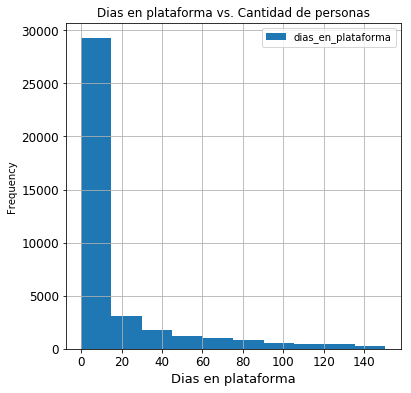

In [24]:
dplat = dias_en_plataforma.plot(kind='hist', figsize=(6,6), grid=True, fontsize=12, title= 'Dias en plataforma vs. Cantidad de personas').set_xlabel('Dias en plataforma', size=13)

In [25]:
dias_en_plataforma.to_csv('dias_en_plataforma_por_persona.csv', index=False)

#### (B) Obtengo la cantidad de eventos en días distintos que tiene cada persona

In [26]:
eventos['fecha'] = eventos['timestamp'].dt.date

Obtengo un dataframe con persona y día en que realizó un evento, con duplicados.

In [27]:
dias_con_eventos = eventos.loc[:,['person', 'fecha']]
dias_con_eventos.shape

(2341681, 2)

In [28]:
dias_con_eventos.head()

,person,fecha
0,4886f805,2018-05-18
1,ad93850f,2018-05-18
2,0297fc1e,2018-05-18
3,2d681dd8,2018-05-18
4,cccea85e,2018-05-18


Quito los duplicados

In [29]:
dias_con_eventos = dias_con_eventos.drop_duplicates()
dias_con_eventos.shape

(138421, 2)

In [30]:
dias_con_eventos_agg = dias_con_eventos.groupby('person').count().reset_index()
dias_con_eventos_agg = dias_con_eventos_agg.rename(columns={'fecha':'dias_distintos_con_eventos'})

In [31]:
dias_con_eventos_agg.head()

,person,dias_distintos_con_eventos
0,0008ed71,1
1,00091926,22
2,00091a7a,1
3,000ba417,3
4,000c79fe,1


In [32]:
dias_con_eventos_agg.shape

(38829, 2)

In [33]:
dias_con_eventos_agg.mean()

dias_distintos_con_eventos    3.564887
dtype: float64

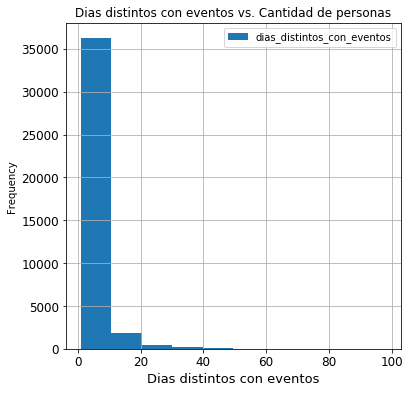

In [74]:
ddev = dias_con_eventos_agg.plot(kind='hist', figsize=(6,6), grid=True, fontsize=12, title= 'Dias distintos con eventos vs. Cantidad de personas').set_xlabel('Dias distintos con eventos', size=13)

In [35]:
dias_con_eventos_agg.to_csv('dias_distintos_con_eventos_por_persona.csv', index=False)

#### (C) Obtengo la cantidad de eventos totales por persona

In [36]:
actividad = eventos.loc[:, ['person', 'event']]
actividad.head()

,person,event
0,4886f805,viewed product
1,ad93850f,viewed product
2,0297fc1e,viewed product
3,2d681dd8,viewed product
4,cccea85e,viewed product


In [37]:
eventos_por_persona = actividad.groupby(['person']).count().reset_index()
eventos_por_persona = eventos_por_persona.rename(columns={'event':'eventos_totales_generados'})
eventos_por_persona.head()

,person,eventos_totales_generados
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


Text(0.5,0,'Persona')

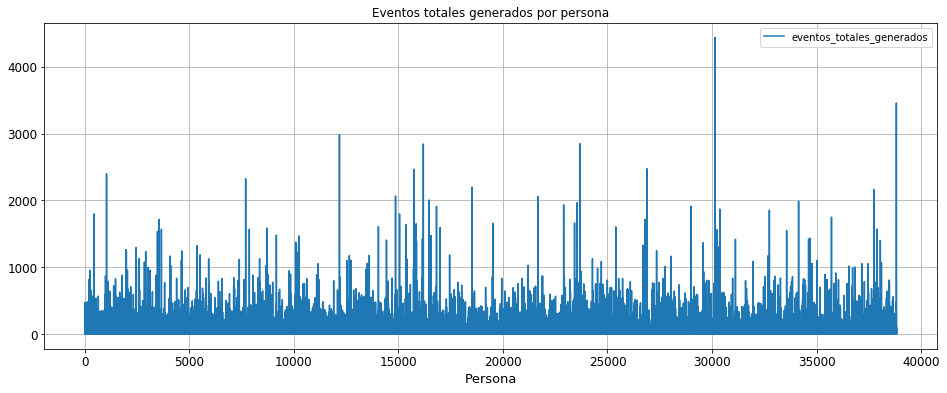

In [75]:
eventos_por_persona.plot(kind='line', figsize=(16,6), grid=True, fontsize=12, title= 'Eventos totales generados por persona').set_xlabel('Persona', size=13)

In [39]:
eventos_por_persona.mean()

eventos_totales_generados    60.307528
dtype: float64

In [40]:
eventos_por_persona.to_csv('eventos_totales_por_persona.csv', index=False)

### Approach 1

El indicador de actividad de usuario approach 1 será generado de la siguiente manera:

nivel_de_actividad_1 = ((A * B) / C)

In [41]:
actividad = pd.merge(left=dias_en_plataforma, right= dias_con_eventos_agg, on='person', how='inner')
actividad.shape

(38829, 3)

In [42]:
actividad.head()

,person,dias_en_plataforma,dias_distintos_con_eventos
0,0008ed71,0.167245,1
1,00091926,27.905255,22
2,00091a7a,0.004016,1
3,000ba417,9.081678,3
4,000c79fe,0.007176,1


Hago el merge de las 3 métricas anteriores

In [43]:
actividad = actividad.merge(eventos_por_persona, on='person', how='inner')
actividad.head()

,person,dias_en_plataforma,dias_distintos_con_eventos,eventos_totales_generados
0,0008ed71,0.167245,1,6
1,00091926,27.905255,22,448
2,00091a7a,0.004016,1,10
3,000ba417,9.081678,3,206
4,000c79fe,0.007176,1,17


Calculo nivel de actividad approach 1

In [44]:
actividad['nivel_de_actividad_1'] = (actividad['eventos_totales_generados'] * actividad['dias_distintos_con_eventos']) / (actividad['dias_en_plataforma'] + 1)


Text(0.5,0,'Persona')

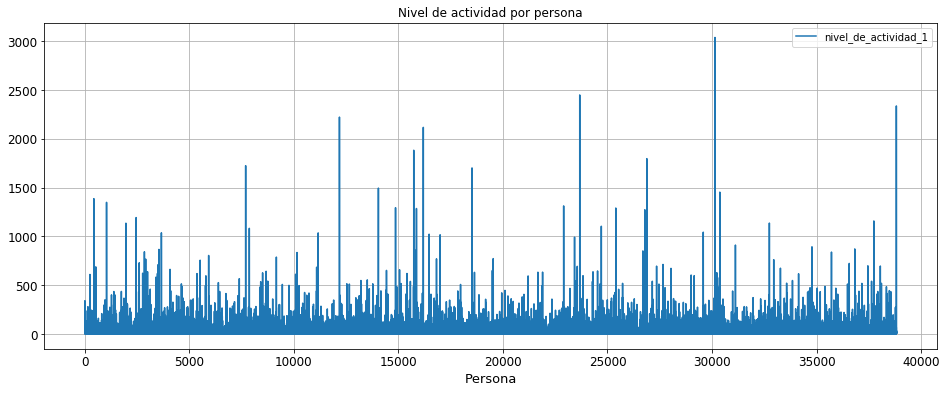

In [77]:
actividad[['person','nivel_de_actividad_1']].plot(kind='line', figsize=(16,6), grid=True, fontsize=12, title= 'Nivel de actividad por persona').set_xlabel('Persona', size=13)

In [46]:
actividad[['person','nivel_de_actividad_1']].mean()

nivel_de_actividad_1    29.335364
dtype: float64

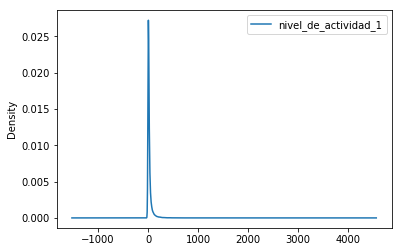

In [47]:
actividad[['person','nivel_de_actividad_1']].plot.density()

### Approach 2

El indicador de actividad de usuario approach 2 será generado de la siguiente manera:

nivel_de_actividad_2 = ((A * B) / (C + B))

In [48]:
actividad['nivel_de_actividad_2'] =  (actividad['eventos_totales_generados'] * actividad['dias_distintos_con_eventos']) / ((actividad['dias_en_plataforma'] + 1) + actividad['dias_distintos_con_eventos'])

In [49]:
actividad.head()

,person,dias_en_plataforma,dias_distintos_con_eventos,eventos_totales_generados,nivel_de_actividad_1,nivel_de_actividad_2
0,0008ed71,0.167245,1,6,5.140307,2.768491
1,00091926,27.905255,22,448,340.976066,193.614590
2,00091a7a,0.004016,1,10,9.959999,4.989980
3,000ba417,9.081678,3,206,61.299318,47.241645
4,000c79fe,0.007176,1,17,16.878878,8.469611


Text(0.5,0,'Persona')

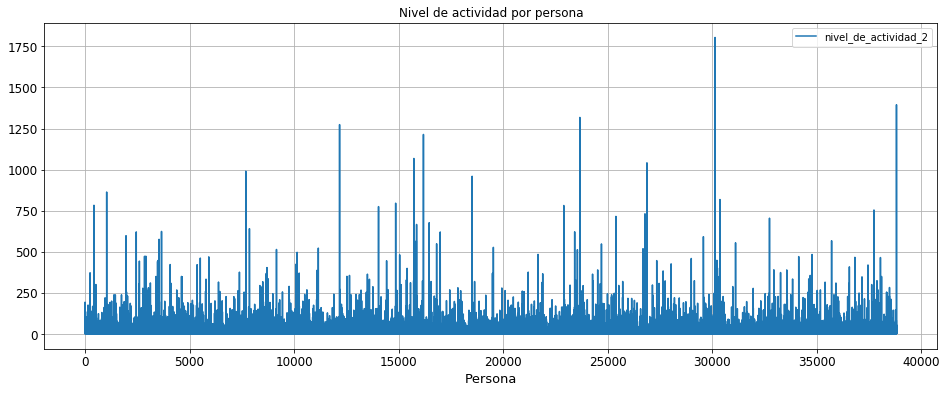

In [78]:
actividad[['person','nivel_de_actividad_2']].plot(kind='line', figsize=(16,6), grid=True, fontsize=12, title= 'Nivel de actividad por persona').set_xlabel('Persona', size=13)

In [51]:
actividad[['person','nivel_de_actividad_2']].mean()

nivel_de_actividad_2    17.806415
dtype: float64

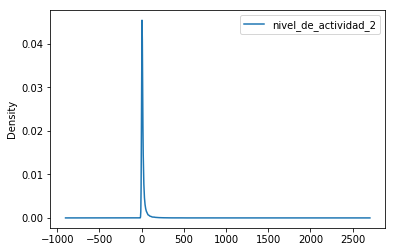

In [52]:
actividad[['person','nivel_de_actividad_2']].plot.density()

### Eleccion de approach y clasificación

Elijo el approach 2 ya que mantiene la proporción del approach 1 que es el más intuitivo, pero reduce la escala.

In [53]:
actividad_approach = actividad[['person', 'nivel_de_actividad_2']]
actividad_approach.head()

,person,nivel_de_actividad_2
0,0008ed71,2.768491
1,00091926,193.614590
2,00091a7a,4.989980
3,000ba417,47.241645
4,000c79fe,8.469611


Criterio para clasificación:

1. Muy Bajo: actividad (0, 5]
2. Bajo:     actividad (5, 10]
3. medio:    actividad (10, 20]
4. alto:     actividad (20, 50]
5. muy alto: actividad (50, +inf]

In [54]:
actividad_aux = pd.cut(actividad_approach['nivel_de_actividad_2'].to_frame().stack(), [0, 5, 10, 20, 50, np.inf], labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])
actividad_approach = actividad_approach.join(actividad_aux.unstack().add_suffix('_categoria'))

In [55]:
actividad_approach = actividad_approach.rename(columns={'nivel_de_actividad_2_categoria':'nivel_de_actividad'})
actividad_approach = actividad_approach.drop('nivel_de_actividad_2',axis=1)
actividad_approach.head()

,person,nivel_de_actividad
0,0008ed71,Muy Bajo
1,00091926,Muy Alto
2,00091a7a,Muy Bajo
3,000ba417,Alto
4,000c79fe,Bajo


In [56]:
actividad_approach['nivel_de_actividad'].value_counts()

Muy Bajo    14547
Bajo         8401
Medio        7496
Alto         5667
Muy Alto     2718
Name: nivel_de_actividad, dtype: int64

Text(0.5,0,'Nivel de actividad')

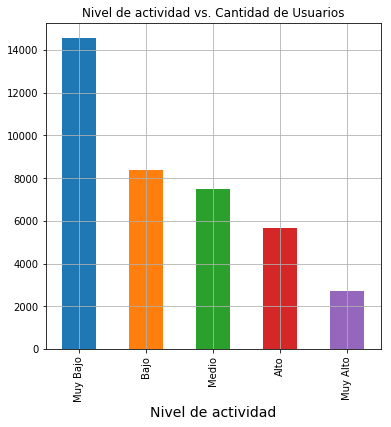

In [81]:
actividad_approach.set_index('person')
actividad_approach['nivel_de_actividad'].value_counts().plot.bar(title="Nivel de actividad vs. Cantidad de Usuarios", grid=True, figsize=(6,6)).set_xlabel('Nivel de actividad', size=14)

In [58]:
actividad_approach.shape

(38829, 2)

## Join de Features y exportación de CSV

Para incorporar las marcas favoritas hago right join con actividad, pues hay algunos usuarios que no tienen marca favorita.

In [59]:
features_gaby = pd.merge(left=marcas_favoritas, right=actividad_approach, on='person', how='right')
features_gaby.head()

,person,marca_favorita,nivel_de_actividad
0,0008ed71,apple,Muy Bajo
1,00091926,apple,Muy Alto
2,00091a7a,apple,Muy Bajo
3,000ba417,samsung,Alto
4,000c79fe,apple,Bajo


In [60]:
features_gaby.shape

(38829, 3)

Los que tienen marca favorita NULL son completados con 'no tiene'

In [61]:
features_gaby['marca_favorita'] = features_gaby['marca_favorita'].fillna(value='no tiene')

In [62]:
features_gaby.to_csv('features_gaby.csv', index=False)

## Categorical Encoding

Se utilizará One Hot Encoding para encodear los atributos categóricos

In [63]:
features_gaby.head()

,person,marca_favorita,nivel_de_actividad
0,0008ed71,apple,Muy Bajo
1,00091926,apple,Muy Alto
2,00091a7a,apple,Muy Bajo
3,000ba417,samsung,Alto
4,000c79fe,apple,Bajo


In [64]:
features_gaby['marca_favorita'].value_counts()

apple       16613
samsung     16410
motorola     4406
no tiene      573
lg            434
sony          192
lenovo        158
asus           32
quantum        11
Name: marca_favorita, dtype: int64

In [65]:
features_gaby['nivel_de_actividad'].value_counts()

Muy Bajo    14547
Bajo         8401
Medio        7496
Alto         5667
Muy Alto     2718
Name: nivel_de_actividad, dtype: int64

In [66]:
features_gaby_encoded = pd.get_dummies(features_gaby, columns=['marca_favorita', 'nivel_de_actividad'])

In [67]:
features_gaby_encoded.to_csv('features_gaby.csv', index=False)